In [1]:
# Programmer Name:  Jacob Yim
# Class: CIS4321 
# Programming Assignment : Final Project
# Date:12/1/21
##############################################

# Import Libraries

In [2]:
#computational
import pandas as pd
import numpy as np

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#sets graph design
sns.set_style("white")

#filters warnings
import warnings

#ignore warnings
warnings.filterwarnings("ignore")

#allow matplotlib to allow graph in notebook
%matplotlib inline

#normalization and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

#import metrics
from sklearn import metrics


# Import Data

In [3]:
energy = pd.read_csv('/content/energy_dataset.csv')

In [4]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


#Exploratory Data Analysis

### Data Exploration

In [5]:
#number of rows and cols
energy.shape

(35064, 29)

In [6]:
#check for duplicates
energy[energy.duplicated()]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual


Notes: 

- There are no duplicated rows

In [7]:
#describe the data
energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


Notes: 

- There are a lot of nan values and 0s.

In [8]:
#since target varibale will be 'price actual'
energy[['price actual']].describe()

,price actual
count,35064.000000
mean,57.884023
std,14.204083
min,9.330000
25%,49.347500
50%,58.020000
75%,68.010000
max,116.800000


Notes: 

- There are no negative prices, which is good.

In [9]:
#check out dtypes
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

Notes: 

- Dtypes look accurate.

In [10]:
#total number of null values
energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

Notes: 

- Some columns have the same amount of null values as rows.
- some rows are fluctuating

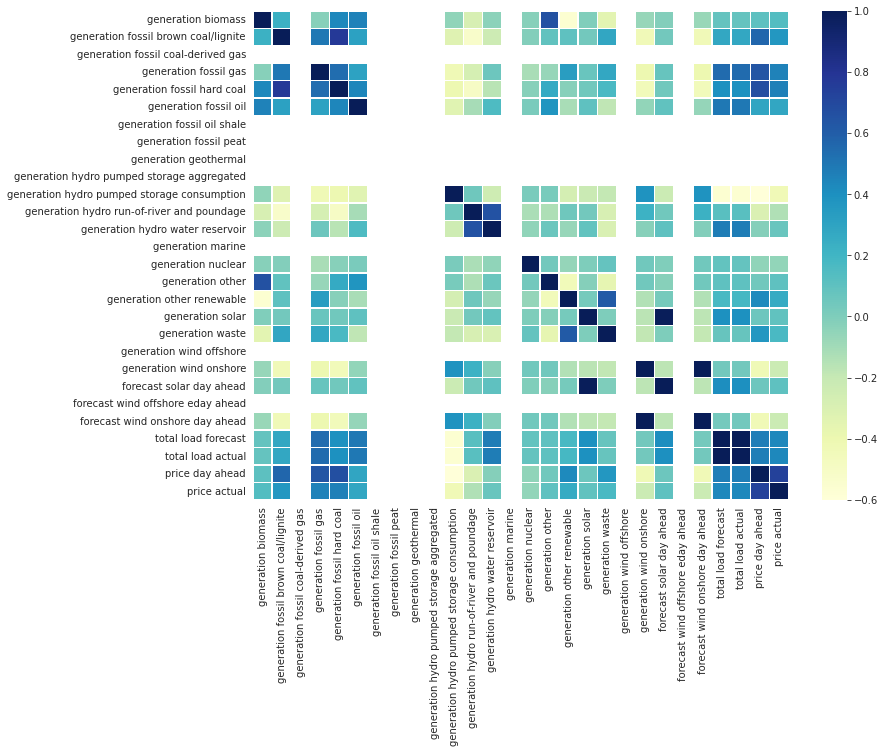

In [11]:
#correlation matrix
corr = energy.corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, linewidths=.5, cmap='YlGnBu');

Notes: 

- Clean up will include the removal of blank rows or items with an index of 0

In [12]:
#these columns are essentially useless since they have 100% rows missing or 0 items
drop_cols = ['generation hydro pumped storage aggregated',
          'forecast wind offshore eday ahead',
          'generation fossil coal-derived gas',
          'generation fossil oil shale',
          'generation fossil peat',
          'generation geothermal',
          'generation marine',
          'generation wind offshore',
          'total load actual',
          'time']

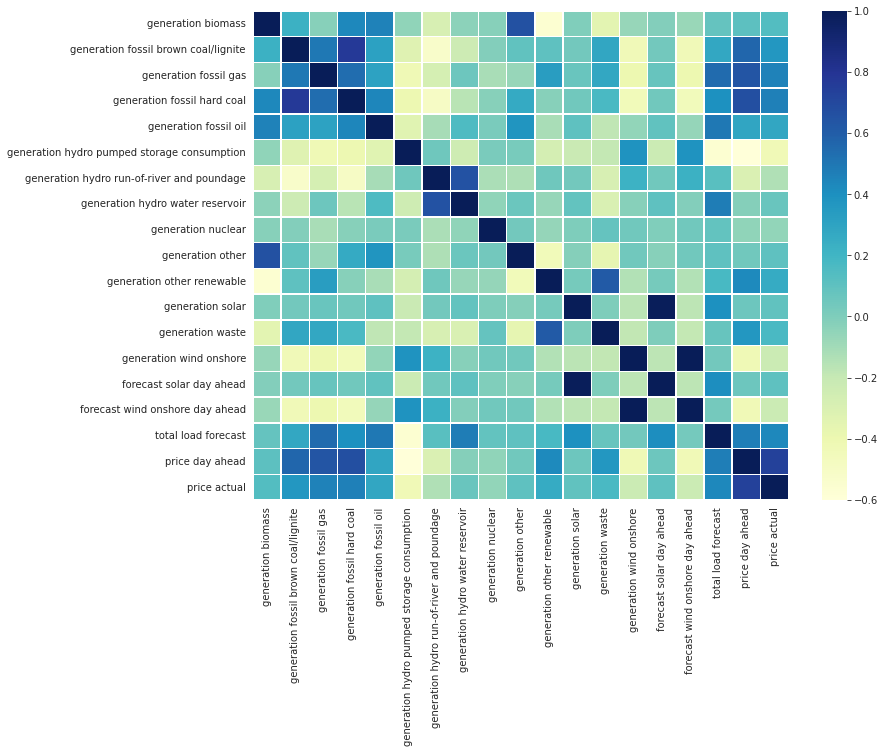

In [13]:
#correlation matrix
corr = energy.drop(drop_cols, axis = 1).corr(method = 'pearson')
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, linewidths=.5, cmap='YlGnBu');

In [14]:
#top 6 correlations to price actual
corr.nlargest(6, 'price actual')['price actual']

price actual                            1.000000
price day ahead                         0.732155
generation fossil hard coal             0.465641
generation fossil gas                   0.461706
total load forecast                     0.435864
generation fossil brown coal/lignite    0.364088
Name: price actual, dtype: float64

Notes

- only price day ahead has a relatively positive correlation, all other values are closer to no correlation at all

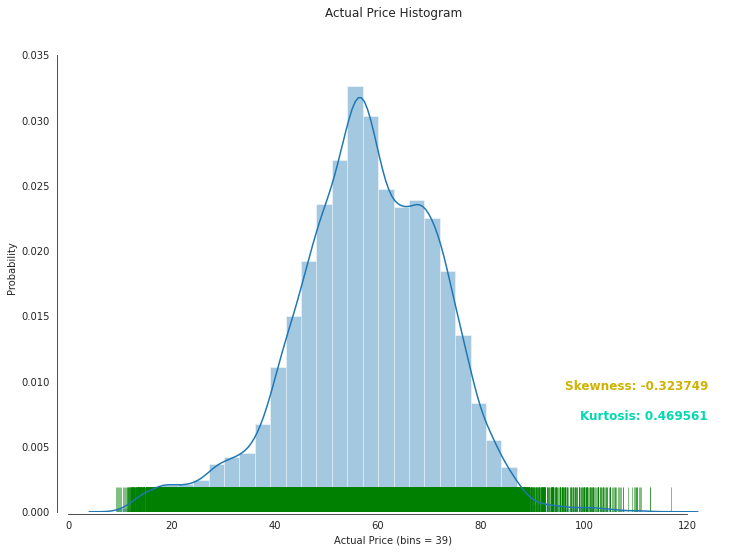

In [15]:
#Sturges Rule number of bins
bins = round(1+3.322*np.log(energy.shape[0]))

#Histogram
fig, ax = plt.subplots(figsize=(12, 9))
#Bins Calculated from the Square Root method
sns.distplot(energy['price actual'], rug=True, rug_kws={'color':'g', 'height':0.05, 'lw':.5}, bins = bins)

#set labels
ax.set_title('Actual Price Histogram')
ax.set_xlabel(f'Actual Price (bins = {39})')
ax.set_ylabel('Probability')

#set legends
ax.text(x=0.97, y=0.27, transform=ax.transAxes, s="Skewness: %f" % energy['price actual'].skew(),\
  fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
  color='xkcd:mustard')
ax.text(x=0.97, y=0.21, transform=ax.transAxes, s="Kurtosis: %f" % energy['price actual'].kurt(),\
  fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
  color='xkcd:aquamarine')



sns.despine(offset=2, trim=True)


Notes: 

- Judging from the skewness, the histogram is fairly symetrical with a relatively normal distribution
- Kurtosis show that the prices are Platykurtic, which is a good indicator of less outliers
- Rugplot shows the distribution of values within histogram, and the values are rather centralized.

### Data Cleaning

In [16]:
#these orginial columns are dropped
energy.drop(columns = drop_cols, inplace = True)

In [17]:
#shows all rows with nan values
energy[energy.isna().any(axis=1)]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,price day ahead,price actual
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,546.0,8233.0,21912.0,35.20,59.68
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3932.0,9258.0,23209.0,35.50,79.14
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236.0,9156.0,23725.0,36.80,73.95
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215.0,9072.0,23614.0,32.50,71.93
111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050.0,8779.0,22381.0,30.00,71.50
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3728.0,8426.0,21371.0,30.00,71.85
113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3175.0,7946.0,20760.0,30.60,80.53
451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,6434.0,38642.0,70.01,88.95
452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,6907.0,38758.0,69.00,87.94
643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0,9807.0,38968.0,66.00,83.97


Notes:    

- threshold of 14 would be sufficient to clean the majority of the dataset

In [18]:
#shows all rows with nan values after a thresh of 14
energy.dropna(thresh =14, axis = 0)[energy.dropna(thresh =14, axis = 0).isna().any(axis=1)]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,price day ahead,price actual
11236,220.0,0.0,3390.0,1242.0,243.0,2270.0,1622.0,4515.0,7097.0,53.0,69.0,150.0,NaN,8596.0,70.0,8557.0,23514.0,18.69,25.14
12672,356.0,595.0,5719.0,6165.0,274.0,382.0,NaN,1325.0,5056.0,56.0,86.0,30.0,291.0,2019.0,9.0,2064.0,24715.0,60.23,48.72
13391,346.0,595.0,5951.0,6131.0,NaN,494.0,709.0,1215.0,5058.0,49.0,83.0,31.0,309.0,2031.0,10.0,2050.0,25313.0,64.99,47.49
15982,351.0,554.0,7176.0,5690.0,321.0,NaN,417.0,1295.0,6967.0,58.0,91.0,70.0,299.0,3193.0,46.0,3143.0,26423.0,55.70,62.84
16612,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,3.0,4566.0,23469.0,43.19,49.11


Notes:    

- There wouldn't be too much data loss if we removed these rows.

In [19]:
#These rows with na values more than 19 will be removed.
energy.dropna(thresh =19, axis = 0).isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
price day ahead                                0
price actual                                   0
dtype: int64

In [20]:
#show number remaining after shape
energy.dropna(thresh =19, axis = 0).shape

(35041, 19)

In [21]:
#confirm dropping the rows and columns
energy.dropna(thresh =19, axis = 0, inplace = True)

Notes:     

- After dropping certain columns and cleaning up rows, the shape shows that we still have a significant amount of data to work with.

# Modeling and Machine Learning

###Split Features and Target Data

In [22]:
#define X and y

#feature matrix
X_defined = energy.drop(columns= ['price actual'])

#target variable
y_defined = energy['price actual']

### Normalize the feature matrix using Standard Scaler and split train test data

In [23]:
#normalize data
X = StandardScaler().fit_transform(X_defined)

In [24]:
#split train test data
X_train, X_test, y_train, y_test = train_test_split(X_defined, y_defined, test_size=0.3, random_state=10)

### Train on Linear Regression Model

In [25]:
#build linear model classifier
lr_model = LinearRegression()

#fit the data
lr_model.fit(X_train,y_train)

#make prediction using X_test data
lr_y_pred = lr_model.predict(X_test)

### Residuals

In [26]:
#create dataframe or results of preddicted, actual, and the residual error
energy_result_df = pd.DataFrame({
    'Predicted': lr_y_pred,
    'Actual': y_test,
    'Residual': y_test - lr_y_pred})

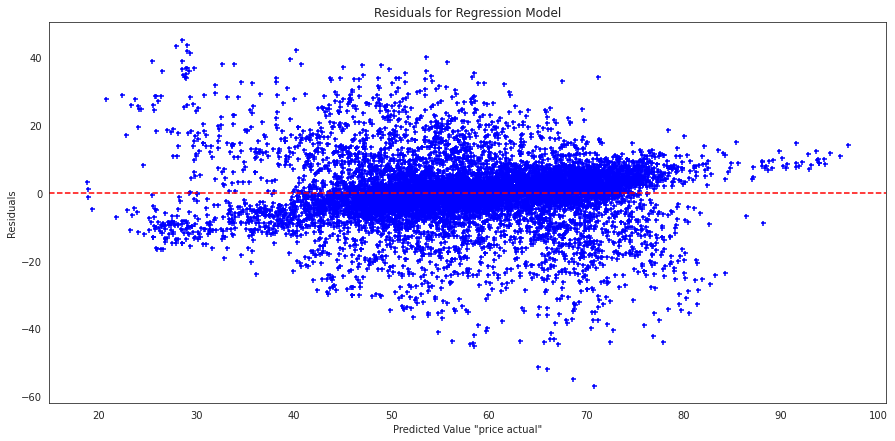

In [27]:
plt.figure(figsize=[15,7])
plt.scatter(energy_result_df.Predicted, energy_result_df.Residual, color = 'b', s = 25, marker = '+')
plt.title('Residuals for Regression Model')
plt.xlabel('Predicted Value "price actual"')
plt.ylabel('Residuals')
plt.axhline(y = 0, color = 'r', ls= '--')

Notes:     

- Most of the residuals lie between 40 and 80 of the predicted value.
- due to the shape of the model, this indicates that there isn't really any form of trending pattern in the algorithm. Linear regression is most likely not a good fit to predict the independent variable. 

### GridSearch

In [28]:
#gridsearch Hyper Parameters 
lr_parameter_space = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'positive' : [True, False],
    'n_jobs' : [-1,1]
}

In [29]:
#gridsearch object
clf_lr = GridSearchCV(lr_model, lr_parameter_space)

#fit the data
clf_lr.fit(X_train,y_train)

#make prediction using X_test data
clf_lr_y_pred = clf_lr.predict(X_test)

### Feature Selection

In [30]:
### Feature Selection
#construct RFE, model select top 6
rfe = RFE(lr_model,n_features_to_select = 6)
#fit the RFE model
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=6)

In [31]:
#tells us what column was selected .. (first column is not selected)
rfe.support_

array([False, False, False, False,  True, False,  True, False, False,
        True,  True, False,  True, False, False, False, False,  True])

In [32]:
#visualize the columns with all columns
selected = pd.DataFrame(data= rfe.support_, index = X_defined.columns)

#shows only RFE True Selection
selected[selected[0]==True]

,0
generation fossil oil,True
generation hydro run-of-river and poundage,True
generation other,True
generation other renewable,True
generation waste,True
price day ahead,True


In [33]:
#shows the top 6 most correlated to price actual
corr.nlargest(6, 'price actual')['price actual']

price actual                            1.000000
price day ahead                         0.732155
generation fossil hard coal             0.465641
generation fossil gas                   0.461706
total load forecast                     0.435864
generation fossil brown coal/lignite    0.364088
Name: price actual, dtype: float64

Notes: 

- Compared to the correlation, only Price Day Ahead was selected in RFE selection

In [34]:
#selects only the columns that are true
X_defined.columns[rfe.support_]

Index(['generation fossil oil', 'generation hydro run-of-river and poundage',
       'generation other', 'generation other renewable', 'generation waste',
       'price day ahead'],
      dtype='object')

In [35]:
#original X_test col
X_test.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,price day ahead
28504,388.0,625.0,4635.0,4454.0,248.0,1.0,909.0,1730.0,7111.0,61.0,96.0,590.0,313.0,4978.0,546.0,5045.0,28623.0,54.10
13685,392.0,0.0,3812.0,2140.0,242.0,1678.0,668.0,653.0,7005.0,56.0,81.0,634.0,320.0,6404.0,481.0,6418.0,21508.0,30.69
32520,368.0,479.0,4332.0,4936.0,262.0,380.0,669.0,766.0,6988.0,57.0,83.0,164.0,324.0,3259.0,149.0,2911.0,23300.0,66.65
34705,294.0,188.0,4459.0,2518.0,212.0,503.0,1360.0,969.0,6102.0,57.0,81.0,14.0,289.0,9918.0,7.0,9473.0,23972.0,51.00
31108,387.0,664.0,4492.0,4088.0,284.0,503.0,1009.0,1195.0,6002.0,55.0,99.0,529.0,301.0,4323.0,432.0,4457.0,25343.0,56.85


In [36]:
#updated X_test
X_test = X_test[X_defined.columns[rfe.support_]]
X_test.head()

,generation fossil oil,generation hydro run-of-river and poundage,generation other,generation other renewable,generation waste,price day ahead
28504,248.0,909.0,61.0,96.0,313.0,54.10
13685,242.0,668.0,56.0,81.0,320.0,30.69
32520,262.0,669.0,57.0,83.0,324.0,66.65
34705,212.0,1360.0,57.0,81.0,289.0,51.00
31108,284.0,1009.0,55.0,99.0,301.0,56.85


In [37]:
#updated X_train
X_train = X_train[X_defined.columns[rfe.support_]]
X_train.head()

,generation fossil oil,generation hydro run-of-river and poundage,generation other,generation other renewable,generation waste,price day ahead
3790,415.0,711.0,86.0,71.0,234.0,60.49
17131,320.0,712.0,56.0,106.0,289.0,73.87
25411,347.0,505.0,56.0,105.0,287.0,70.66
32931,284.0,1878.0,12.0,92.0,333.0,28.05
30556,287.0,1316.0,54.0,89.0,307.0,60.96


In [38]:
#rebuld MLR model using the subset columns
lr_model.fit(X_train, y_train)

#make prediction using X_test data
rfe_lr_y_pred = lr_model.predict(X_test)

# Accuracy Reports

In [39]:
#explained variance no gridsearch
print("R2: ", metrics.r2_score(y_test, lr_y_pred).round(2))                      #the higher the better
print("MSE: ", metrics.mean_squared_error(y_test, lr_y_pred).round(2))           #the lower the better
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, lr_y_pred)).round(2)) #lower the better


R2:  0.56
MSE:  88.79
RMSE:  9.42


In [40]:
#explained variance with gridsearch
print("R2: ", metrics.r2_score(y_test, clf_lr_y_pred).round(2))                      #the higher the better
print("MSE: ", metrics.mean_squared_error(y_test, clf_lr_y_pred).round(2))           #the lower the better
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, clf_lr_y_pred)).round(2)) #lower the better

R2:  0.56
MSE:  88.79
RMSE:  9.42


In [41]:
#explained variance with RFE Feature Selection
print("R2: ", metrics.r2_score(y_test, rfe_lr_y_pred).round(2))                      #the higher the better
print("MSE: ", metrics.mean_squared_error(y_test, rfe_lr_y_pred).round(2))           #the lower the better
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, rfe_lr_y_pred)).round(2)) #lower the better

R2:  0.54
MSE:  92.33
RMSE:  9.61


In [42]:
#data
a_lr = [metrics.r2_score(y_test, lr_y_pred), 
        metrics.mean_squared_error(y_test, lr_y_pred),
        np.sqrt(metrics.mean_squared_error(y_test, lr_y_pred))
        ]

gs_lr = [metrics.r2_score(y_test, clf_lr_y_pred), 
        metrics.mean_squared_error(y_test, clf_lr_y_pred),
        np.sqrt(metrics.mean_squared_error(y_test, clf_lr_y_pred))
        ]

rfe_lr = [metrics.r2_score(y_test, rfe_lr_y_pred), 
        metrics.mean_squared_error(y_test, rfe_lr_y_pred),
        np.sqrt(metrics.mean_squared_error(y_test, rfe_lr_y_pred))
        ]

#dataframe df
accuracy_df = pd.DataFrame(np.array([a_lr, gs_lr, rfe_lr]),
                              index = ['Linear Regression Model', 'GridSearch Linear Regression Model', 'RFE Linear Regression Model'],
                              columns=['R2', 'MSE', 'RMSE'])
accuracy_df

,R2,MSE,RMSE
Linear Regression Model,0.560213,88.788416,9.422761
GridSearch Linear Regression Model,0.560213,88.788416,9.422761
RFE Linear Regression Model,0.542677,92.328898,9.608793


Notes:     

- Linear Regression Model showed low accuracy on all metrics.
- Gridsearch showed the same accuracy on all metrics. The linear regression model without hyperparameters is already the best result.
- With Recursive Feature Elimination (RFE), there is a significant amount of data removal, which should stem with higher accuracy. Since this metric shows lower accuracy than without feature importance, there must be other columns that are important within the dataset that justifies its accuracy. 